In [0]:
import pandas as pd
import numpy as np
import random
import csv
import os
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk

from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from scipy import sparse


import matplotlib.pyplot as mp
%matplotlib inline
# Code source: https://degravek.github.io/project-pages/project1/2017/04/28/New-Notebook/
# Dataset from Chakraborty et al. (https://github.com/bhargaviparanjape/clickbait/tree/master/dataset)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Mount Google Drive


In [0]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load Dataset


In [0]:
! ls '/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/liar_dataset'

README	test.tsv  train.tsv  valid.tsv


# Column names
* Column 1: the ID of the statement ([ID].json).
* Column 2: the label.
* Column 3: the statement.
* Column 4: the subject(s).
* Column 5: the speaker.
* Column 6: the speaker's job title.
* Column 7: the state info.
* Column 8: the party affiliation.
* Column 9-13: the total credit history count, including the current statement.
* 9: barely true counts.
* 10: false counts.
* 11: half true counts.
* 12: mostly true counts.
* 13: pants on fire counts.
* Column 14: the context (venue / location of the speech or statement).

In [0]:
colnames=['id', 'label', 'statement', 'subject','speaker','speaker_title','state_info','party_affiliation','barely_true_count','false_count','half_true_count','mostly_true_count','pants_on_fire','context'] 
len(colnames)

14

In [0]:

fake_data = pd.read_csv('/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/liar_dataset/train.tsv',names=colnames, delimiter='\t',encoding='utf-8')
fake_data.head(5)


,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [0]:
fake_data.shape

(10240, 14)

In [0]:
print(fake_data['subject'].nunique())
print(fake_data['speaker'].nunique())
fake_data['context'].nunique()

3827
2910


4345

* Label count 
* False/True count Vs Speaker 
* False/True count Vs Party Affilitation
* False/True count Vs Speaker Title
* False/True count Vs subject
* False/True count Vs context
* Most common words for False news
* Most common words for True news

* statement sensation


# Preprocessing 

In [0]:
fake_data.isna().sum()

id                      0
label                   0
statement               0
subject                 2
speaker                 2
speaker_title        2897
state_info           2208
party_affiliation       2
barely_true_count       2
false_count             2
half_true_count         2
mostly_true_count       2
pants_on_fire           2
context               102
dtype: int64

In [0]:
fake_data[fake_data['speaker_title'].isna()][['speaker','speaker_title','subject','party_affiliation']]

,speaker,speaker_title,subject,party_affiliation
3,blog-posting,NaN,health-care,none
4,charlie-crist,NaN,"economy,jobs",democrat
6,republican-party-texas,NaN,candidates-biography,republican
8,oregon-lottery,NaN,jobs,organization
13,doonesbury,NaN,"economy,federal-budget,health-care",none
...,...,...,...,...
10234,david-axelrod,NaN,"corporations,elections",democrat
10235,aclu-florida,NaN,"animals,elections",none
10236,alan-powell,NaN,elections,republican
10237,herman-cain,NaN,"retirement,social-security",republican


In [0]:
fake_data[fake_data['party_affiliation'] == 'none'].shape

(1744, 14)

# Data Visualizations

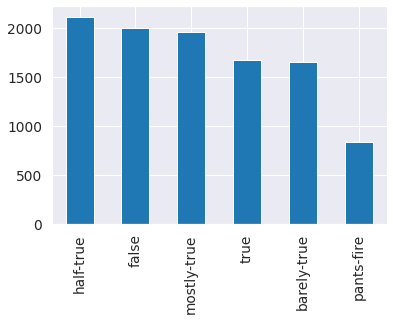

In [0]:
fake_data['label'].value_counts().plot(kind="bar")
plt.show()

In [0]:
fake_data.dtypes

id                    object
label                 object
statement             object
subject               object
speaker               object
speaker_title         object
state_info            object
party_affiliation     object
barely_true_count    float64
false_count          float64
half_true_count      float64
mostly_true_count    float64
pants_on_fire        float64
context               object
dtype: object

In [0]:
fake_data['subject_codes'] = fake_data['subject'].astype('category').cat.codes
fake_data['speaker_codes'] = fake_data['speaker'].astype('category').cat.codes
fake_data['party_affiliation_codes'] = fake_data['party_affiliation'].astype('category').cat.codes
fake_data['speaker_title_codes'] = fake_data['speaker_title'].astype('category').cat.codes
fake_data['label_codes'] = fake_data['label'].astype('category').cat.codes
fake_data['context_codes'] = fake_data['context'].astype('category').cat.codes

fake_data.head(2)

,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context,subject_codes,speaker_codes,party_affiliation_codes,speaker_title_codes,label_codes,context_codes
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,30,814,19,869,1,1313
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,2570,2491,5,867,2,1153


## Correlation Map

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 11 Text major ticklabel objects>)

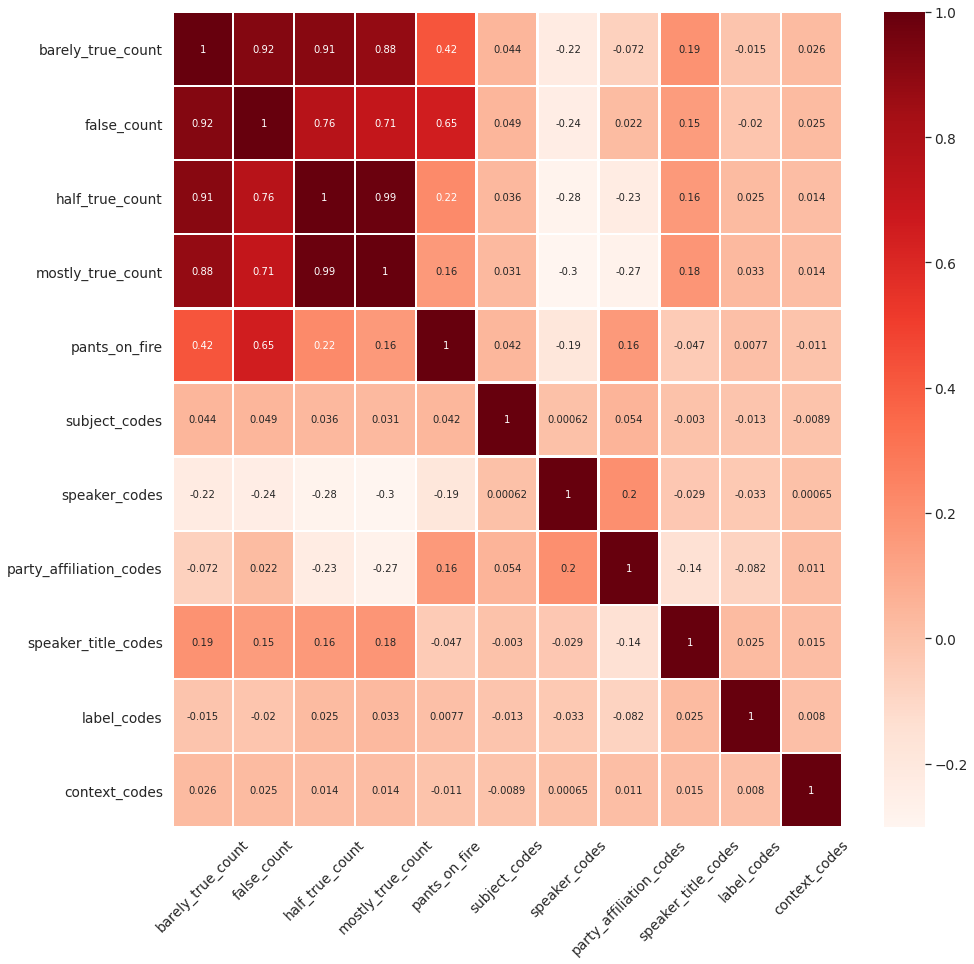

In [0]:
figure, axes = mp.subplots(figsize=(15,15))
sns.heatmap(fake_data.corr(), annot=True, vmax=1, linewidths=1.5, cmap='Reds')
mp.xticks(rotation=45)

## Processing complete data

In [0]:
from nltk.tokenize import word_tokenize


def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """

    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = text.split()
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
        
        text = ' '.join(word for word in text)

    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [0]:
fake_data['statement_processed'] = fake_data['statement'].apply(apply_all)


## Processing False news

Mostly commonly used word in false news

In [0]:
fake_data['label'].unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

In [0]:
false_data = fake_data[(fake_data['label'] == 'false') | (fake_data['label'] == 'pants-fire')]
true_data = fake_data[(fake_data['label'] == 'true') | (fake_data['label'] == 'mostly-true')]

In [0]:
print(false_data.head(2))
print(true_data.head(2))

          id  ...                                statement_processed
0  2635.json  ...  say anni list polit group support thirdtrimest...
3  1123.json  ...  health care reform legisl like mandat free sex...

[2 rows x 21 columns]
           id  ...                                statement_processed
2    324.json  ...  hillari clinton agre john mccain vote give geo...
5  12465.json  ...  chicago bear start quarterback last year total...

[2 rows x 21 columns]


In [0]:
stem_words(remove_stop_words(initial_clean('Hello How are you family anniversary world peace')))

'hello famili anniversari world peac'

## Remove punctuation and lower casing 

In [0]:
false_data['statement_processed'] = false_data['statement'].apply(apply_all)

false_data.head(2)

,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context,subject_codes,speaker_codes,party_affiliation_codes,speaker_title_codes,label_codes,context_codes,statement_processed
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,30,814,19,869,1,1313,say anni list polit group support thirdtrimest...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,3075,272,16,-1,1,1403,health care reform legisl like mandat free sex...


In [0]:
# Load the regular expression library
import re
# Remove punctuation
false_data['statement_processed'] = false_data['statement'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
false_data['statement_processed'] = false_data['statement_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
false_data['statement_processed'].head()

0     says the annies list political group supports ...
3     health care reform legislation is likely to ma...
12    when mitt romney was governor of massachusetts...
20    women and men both are making less when you ad...
25                 i dont know who (jonathan gruber) is
Name: statement_processed, dtype: object

## Word Cloud Visualization

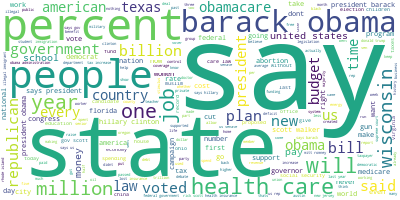

In [0]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(false_data['statement_processed'] .values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Prepare text for LDA Analysis

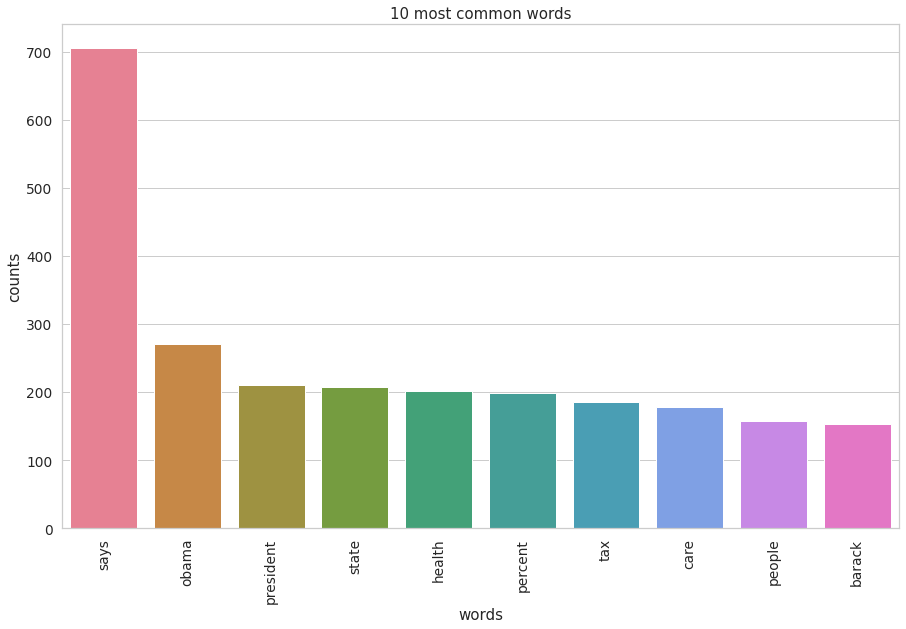

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(false_data['statement_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

## Processing True News

In [0]:
# Load the regular expression library
import re
# Remove punctuation
true_data['statement_processed'] = true_data['statement'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
true_data['statement_processed'] = true_data['statement_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
true_data['statement_processed'].head()

2     hillary clinton agrees with john mccain "by vo...
5     the chicago bears have had more starting quart...
9     says gop primary opponents glenn grothman and ...
10    for the first time in history the share of the...
13    the economy bled $24 billion due to the govern...
Name: statement_processed, dtype: object

In [0]:
true_data['statement_processed'] = true_data['statement'].apply(apply_all)

true_data.head(2)

,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context,subject_codes,speaker_codes,party_affiliation_codes,speaker_title_codes,label_codes,context_codes,statement_processed
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,2863,182,5,642,3,79,hillari clinton agre john mccain vote give geo...
5,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,2311,2380,19,977,5,700,chicago bear start quarterback last year total...


## World cloud visualization - True news

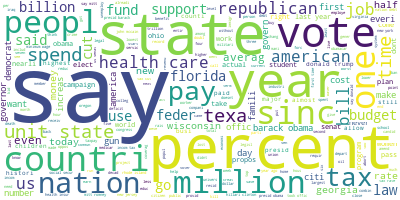

In [0]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(true_data['statement_processed'] .values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Prepare data for LDA Analysis

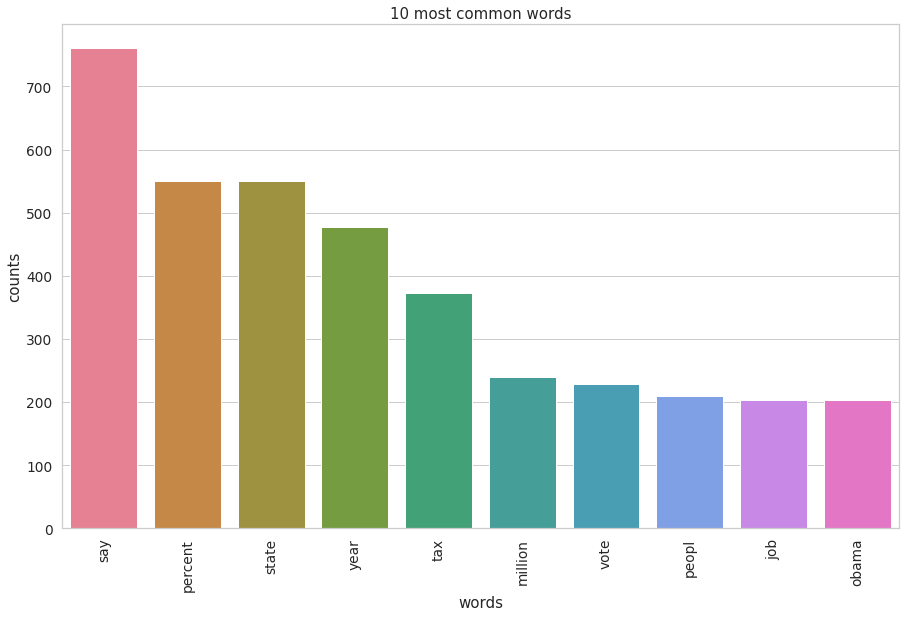

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(true_data['statement_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

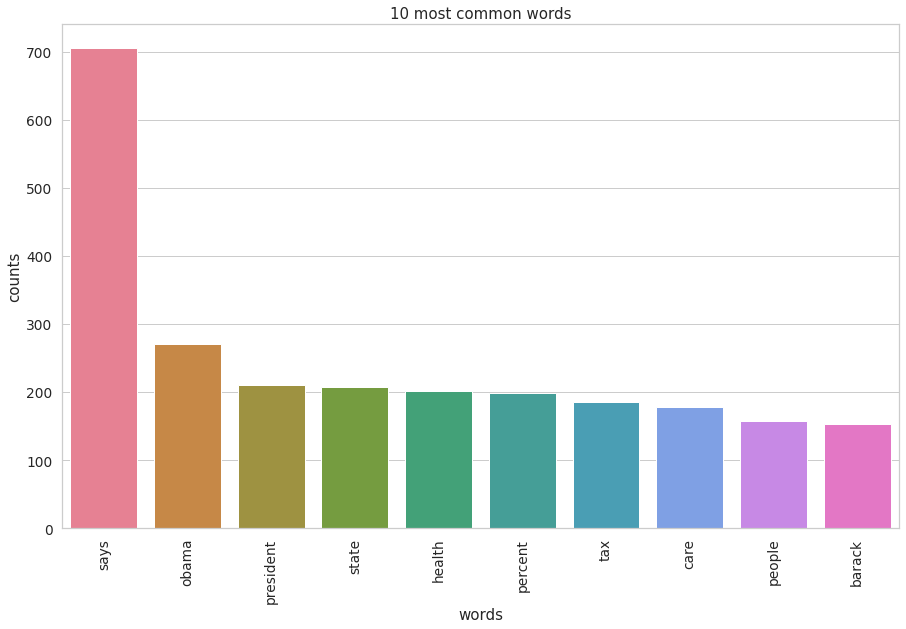

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(false_data['statement_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

## Sentiment Analysis on News Article

In [0]:
fake_data.head(2)

,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context,subject_codes,speaker_codes,party_affiliation_codes,speaker_title_codes,label_codes,context_codes,statement_processed
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,30,814,19,869,1,1313,say anni list polit group support thirdtrimest...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,2570,2491,5,867,2,1153,declin coal start start natur ga took start be...


In [0]:
fake_data['negative'] = 0.0
fake_data['neutral'] = 0.0
fake_data['positive'] = 0.0

fake_data['compound'] = 0.0


In [0]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()

headlines = fake_data['statement'].tolist()
ids = fake_data['id'].tolist()
for index in range(0,len(headlines)):
    line = headlines[index]
    if not pd.isna(line):
      pol_score = senti.polarity_scores(line)
      #print(pol_score)
      id = ids[index]
      fake_data.loc[fake_data['id'] == id, ['negative']] = pol_score['neg']# [neg,neu,pos,compound]
      fake_data.loc[fake_data['id'] == id, ['neutral']] = pol_score['neu']
      fake_data.loc[fake_data['id'] == id, ['positive']] = pol_score['pos']
      fake_data.loc[fake_data['id'] == id, ['compound']] = pol_score['compound']
      if index % 500 == 0:
        print("processing ",index,' of ',len(headlines))
      
fake_data.head(2)

processing  0  of  10240
processing  500  of  10240
processing  1000  of  10240
processing  1500  of  10240
processing  2000  of  10240
processing  2500  of  10240
processing  3000  of  10240
processing  3500  of  10240
processing  4000  of  10240
processing  4500  of  10240
processing  5000  of  10240
processing  5500  of  10240
processing  6000  of  10240
processing  6500  of  10240
processing  7000  of  10240
processing  7500  of  10240
processing  8000  of  10240
processing  8500  of  10240
processing  9000  of  10240
processing  9500  of  10240
processing  10000  of  10240


,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context,subject_codes,speaker_codes,party_affiliation_codes,speaker_title_codes,label_codes,context_codes,statement_processed,negative,neutral,positive,compound
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,30,814,19,869,1,1313,say anni list polit group support thirdtrimest...,0.115,0.692,0.192,0.2500
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,2570,2491,5,867,2,1153,declin coal start start natur ga took start be...,0.000,0.902,0.098,0.3612


(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

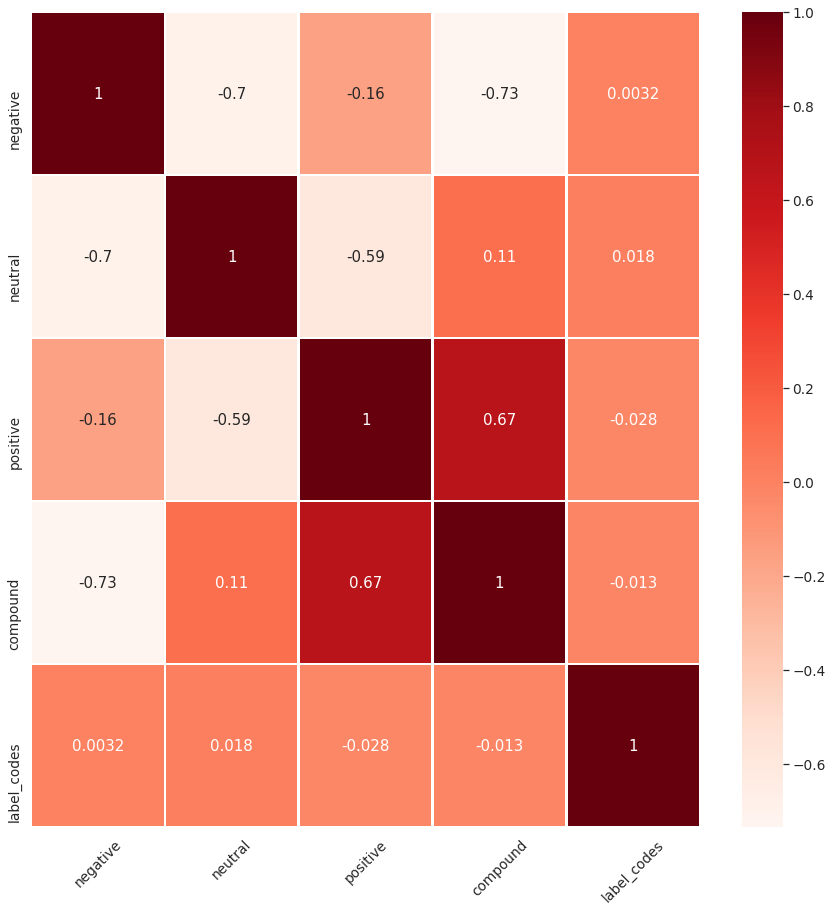

In [0]:
cols = ['negative','neutral','positive','compound','label_codes']

figure, axes = mp.subplots(figsize=(15,15))
sns.heatmap(fake_data[cols].corr(), annot=True, vmax=1, linewidths=1.5, cmap='Reds')
mp.xticks(rotation=45)

# Preprocessing Second dataset (Kaggle)


## Load dataset

In [0]:
# Load Dataset from drive
kaggle_data = pd.read_csv('/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/fake.csv', low_memory =False)
kaggle_data.head(2)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias


In [0]:
print(kaggle_data.shape)
kaggle_data.dtypes

(12999, 20)


uuid                   object
ord_in_thread           int64
author                 object
published              object
title                  object
text                   object
language               object
crawled                object
site_url               object
country                object
domain_rank           float64
thread_title           object
spam_score            float64
main_img_url           object
replies_count           int64
participants_count      int64
likes                   int64
comments                int64
shares                  int64
type                   object
dtype: object

## Find missing value

In [0]:
kaggle_data.isna().sum()

uuid                     0
ord_in_thread            0
author                2424
published                0
title                  680
text                    46
language                 0
crawled                  0
site_url                 0
country                176
domain_rank           4223
thread_title            12
spam_score               0
main_img_url          3643
replies_count            0
participants_count       0
likes                    0
comments                 0
shares                   0
type                     0
dtype: int64

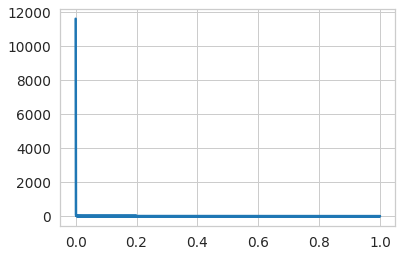

In [0]:
kaggle_data['spam_score'].value_counts().plot(kind="line")
plt.show()

In [0]:
kaggle_data[kaggle_data['title'] == kaggle_data['thread_title']]

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12908,613e1a6e130b5a3f5df62c8fb0b73667742a43db,0,NaN,2016-10-26T21:28:00.000+03:00,Tesla Earnings Smash Expectations After Dramat...,"Oct 26, 2016 4:26 PM 0 SHARES \nThere was a su...",english,2016-10-26T23:32:01.992+03:00,zerohedge.com,CH,2435.0,Tesla Earnings Smash Expectations After Dramat...,0.010,NaN,0,0,21,0,21,bs
12909,dedc36a34e5cb1062bf4627d314227f60cd9a708,0,Tyler Durden,2016-10-26T23:53:43.161+03:00,Rules For Rulers (Or How The World Really Works),"The following video is a must watch, particula...",english,2016-10-26T23:53:43.161+03:00,zerohedge.com,US,2435.0,Rules For Rulers (Or How The World Really Works),0.000,NaN,0,1,72,0,72,bs
12910,cd8bb1ae426287f3a63c2979b3b5dfb0277b10e2,0,George Washington,2016-10-26T23:53:49.879+03:00,Fact Check: Trump Is Right that Clinton Might ...,She explains : \nHillary Clinton wants to star...,english,2016-10-26T23:53:49.879+03:00,zerohedge.com,US,2435.0,Fact Check: Trump Is Right that Clinton Might ...,0.000,NaN,0,1,333,0,333,bs
12911,213eb9eeb5479ad2588b54b24acd53bc8ead8e8c,0,Tyler Durden,2016-10-27T00:20:00.111+03:00,Caught On Tape: ISIS Destroys Iraqi Abrams Wit...,"YHC-FTSE Oct 26, 2016 5:14 PM \nWould have bee...",english,2016-10-27T00:20:00.111+03:00,zerohedge.com,US,2435.0,Caught On Tape: ISIS Destroys Iraqi Abrams Wit...,0.000,NaN,0,1,197,0,197,bs


In [0]:
print(kaggle_data.shape)
kaggle_data_filtered = kaggle_data[kaggle_data['text'].notna()]
print(kaggle_data_filtered.shape)

(12999, 20)
(12953, 20)


In [0]:
kaggle_data_filtered['text_processed'] = kaggle_data_filtered['text'].apply(apply_all)

kaggle_data_filtered.head(2)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,text_processed
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,print pay back money plu interest entir famili...
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,attorney gener loretta lynch plead fifth barra...


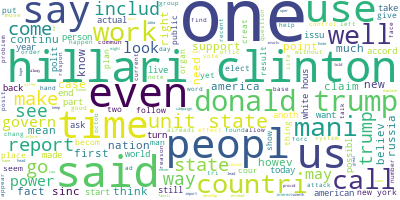

In [0]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(kaggle_data_filtered['text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

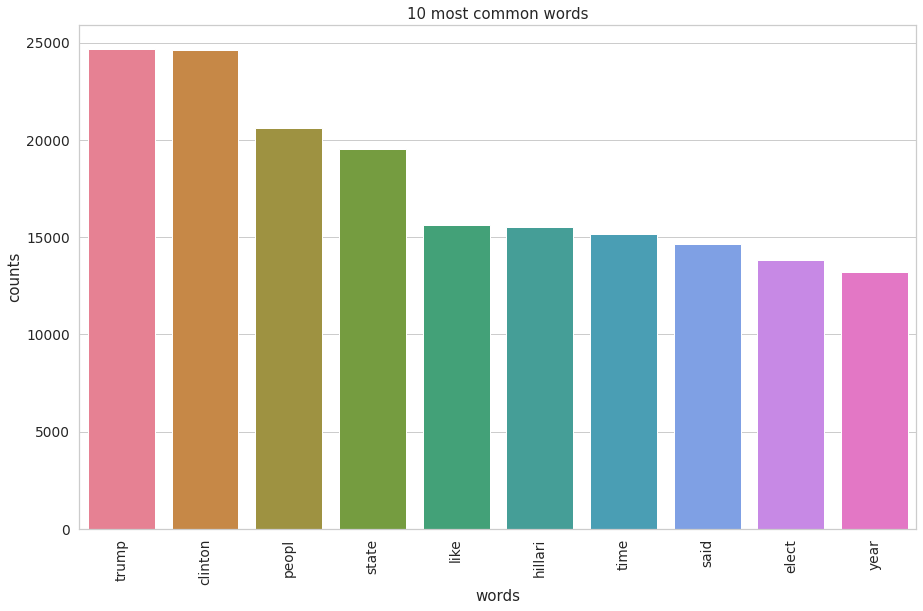

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(kaggle_data_filtered['text_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [0]:
kaggle_data_filtered['negative'] = 0.0
kaggle_data_filtered['neutral'] = 0.0
kaggle_data_filtered['positive'] = 0.0
kaggle_data_filtered['compound'] = 0.0


In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()

headlines = kaggle_data_filtered['text_processed'].tolist()
ids = kaggle_data_filtered['uuid'].tolist()
for index in range(0,len(headlines)):
    line = headlines[index]
    if not pd.isna(line):
      pol_score = senti.polarity_scores(line)
      #print(pol_score)
      id = ids[index]
      kaggle_data_filtered.loc[kaggle_data_filtered['uuid'] == id, ['negative']] = pol_score['neg']# [neg,neu,pos,compound]
      kaggle_data_filtered.loc[kaggle_data_filtered['uuid'] == id, ['neutral']] = pol_score['neu']
      kaggle_data_filtered.loc[kaggle_data_filtered['uuid'] == id, ['positive']] = pol_score['pos']
      kaggle_data_filtered.loc[kaggle_data_filtered['uuid'] == id, ['compound']] = pol_score['compound']
      if index % 500 == 0:
        print("processing ",index,' of ',len(headlines))
      
kaggle_data_filtered.head(2)

processing  0  of  12953
processing  500  of  12953
processing  1000  of  12953
processing  1500  of  12953
processing  2000  of  12953
processing  2500  of  12953
processing  3000  of  12953
processing  3500  of  12953
processing  4000  of  12953
processing  4500  of  12953
processing  5000  of  12953
processing  5500  of  12953
processing  6000  of  12953
processing  6500  of  12953
processing  7000  of  12953
processing  7500  of  12953
processing  8000  of  12953
processing  8500  of  12953
processing  9000  of  12953
processing  9500  of  12953
processing  10000  of  12953
processing  10500  of  12953
processing  11000  of  12953
processing  11500  of  12953
processing  12000  of  12953
processing  12500  of  12953


,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,text_processed,negative,neutral,positive,compound
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,print pay back money plu interest entir famili...,0.199,0.625,0.176,-0.3400
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,attorney gener loretta lynch plead fifth barra...,0.080,0.872,0.048,-0.6908




* Speaker with maximum number of label
* 



In [0]:
fake_data.dtypes

id                          object
label                       object
statement                   object
subject                     object
speaker                     object
speaker_title               object
state_info                  object
party_affiliation           object
barely_true_count          float64
false_count                float64
half_true_count            float64
mostly_true_count          float64
pants_on_fire              float64
context                     object
subject_codes                int16
speaker_codes                int16
party_affiliation_codes       int8
speaker_title_codes          int16
label_codes                   int8
context_codes                int16
statement_processed         object
negative                   float64
neutral                    float64
positive                   float64
compound                   float64
dtype: object

In [0]:
kaggle_data_filtered.dtypes

uuid                   object
ord_in_thread           int64
author                 object
published              object
title                  object
text                   object
language               object
crawled                object
site_url               object
country                object
domain_rank           float64
thread_title           object
spam_score            float64
main_img_url           object
replies_count           int64
participants_count      int64
likes                   int64
comments                int64
shares                  int64
type                   object
text_processed         object
negative              float64
neutral               float64
positive              float64
compound              float64
dtype: object

In [0]:
fake_data[['label','label_codes']].head(10)

# false -1 - 0
# half -true = 2 -0
# mostly-true  3 -1
# pants-fire	4 -0
#barely-true	-0 - 0
#true=5 - 1

,label,label_codes
0,false,1
1,half-true,2
2,mostly-true,3
3,false,1
4,half-true,2
5,true,5
6,barely-true,0
7,half-true,2
8,half-true,2
9,mostly-true,3


In [0]:
fake_data[(fake_data['label_codes'] == 1)].head(2)

,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context,subject_codes,speaker_codes,party_affiliation_codes,speaker_title_codes,label_codes,context_codes,statement_processed,negative,neutral,positive,compound
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,30,814,19,869,1,1313,say anni list polit group support thirdtrimest...,0.115,0.692,0.192,0.2500
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,3075,272,16,-1,1,1403,health care reform legisl like mandat free sex...,0.000,0.606,0.394,0.7579


In [0]:
# false -1 - 0
# half -true = 2 -0
# mostly-true  3 -1
# pants-fire	4 -0
#barely-true	-0 - 0
#true=5 - 1

In [0]:
fake_data_ = fake_data.copy()
fake_data['fake_label'] = fake_data['label_codes'].apply(lambda x: 1 if (int(x) ==3 or int(x) == 5)  else 0)

In [0]:
kaggle_data_filtered.dtypes

uuid                   object
ord_in_thread           int64
author                 object
published              object
title                  object
text                   object
language               object
crawled                object
site_url               object
country                object
domain_rank           float64
thread_title           object
spam_score            float64
main_img_url           object
replies_count           int64
participants_count      int64
likes                   int64
comments                int64
shares                  int64
type                   object
text_processed         object
negative              float64
neutral               float64
positive              float64
compound              float64
dtype: object

In [0]:
np.mean(kaggle_data_filtered['spam_score'].values)

0.026214622095267506

In [0]:
meanValue = np.mean(kaggle_data_filtered['spam_score'].values)
kaggle_data_filtered['fake_label'] = kaggle_data_filtered['spam_score'].apply(lambda x: 0 if x <= meanValue else 1)

Intensionally, adding column published to match with other side

In [0]:
fake_data['published'] = kaggle_data_filtered['published'][0]

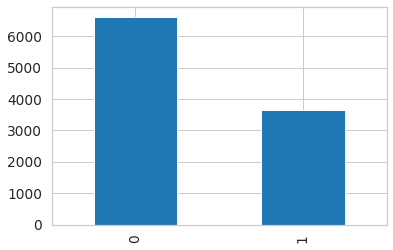

In [0]:
fake_data['fake_label'].value_counts().plot(kind="bar")
plt.show()

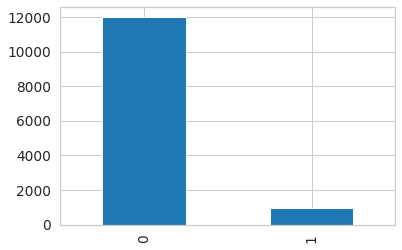

In [0]:
kaggle_data_filtered['fake_label'].value_counts().plot(kind="bar")
plt.show()

## Keyword extraction for dataset 1

### Computing TF-IDF and Extracting Keywords


In [0]:

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

def get_keywords(text):

    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([text]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    
    return keywords   

In [0]:
feature_names=cv.get_feature_names()

fake_data['keywords'] = fake_data['statement_processed'].apply(get_keywords)
fake_data['keywords']

In [0]:
fake_data.head(2)

,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context,subject_codes,speaker_codes,party_affiliation_codes,speaker_title_codes,label_codes,context_codes,statement_processed,negative,neutral,positive,compound,fake_label,published
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,30,814,19,869,1,1313,say anni list polit group support thirdtrimest...,0.115,0.692,0.192,0.2500,0,2016-10-26T21:41:00.000+03:00
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,2570,2491,5,867,2,1153,declin coal start start natur ga took start be...,0.000,0.902,0.098,0.3612,0,2016-10-26T21:41:00.000+03:00


## Keyword extraction for dataset 2

In [0]:
docs = kaggle_data_filtered['text_processed'].values
cv = CountVectorizer(max_df=0.85,stop_words=stopwords)
word_count_vector=cv.fit_transform(docs)

TypeError: ignored

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

NameError: ignored

In [0]:
tfidf_transformer.idf_


In [0]:
list(cv.get_feature_names())[2000:2015]


NameError: ignored

### Td-IDF 

In [0]:
word_count_vector.shape


In [0]:

docs = fake_data['statement_processed'].values
cv=CountVectorizer(max_df=0.85,stop_words=stopwords)
word_count_vector=cv.fit_transform(docs)

In [0]:

def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)
 
#load a set of stop words
stopwords=get_stop_words("/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/stopwords.txt")
print(len(stopwords))
char_splitter = re.compile("[.,;!:()-]")


In [0]:
# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])

## Amalgamanation
* Phrase extraction
* keywords
* before merging clean the dataframe
* merge the same keywords (outer join)
* 

In [0]:
features_cols1 = ['id','subject','statement','fake_label','speaker','published','negative','neutral','positive','compound','keywords']
features_cols2 = ['uuid','title','text','fake_label','author','published','negative','neutral','positive','compound','keywords']

In [0]:
fake_data_df = fake_data[features_cols1]
kaggle_data_df = kaggle_data_filtered[features_cols2]
print('Liar Liar dataset shape: ',fake_data_df.shape)
print('Kaggle dataset shape: ',kaggle_data_df.shape)



In [0]:
kaggle_data_df.columns = features_cols1
kaggle_data_df.head(2)

### Concatenate data 

In [0]:
df_fake = pd.concat([fake_data_df, kaggle_data_df], names=[features_cols1],ignore_index=True)
df_fake.reset_index()
df_fake.shape

In [0]:
df_fake.to_csv('Liar_kaggle_concat.csv')

In [0]:
df_fake.tail()

### Doc2Vec model

In [0]:
def read_token(text):
  #print(text)
  tokens = gensim.utils.simple_preprocess(text)
  return tokens


In [0]:
def read_corpus(text):
  #print(text)
  tokens = gensim.utils.simple_preprocess(text)
  
  return gensim.models.doc2vec.TaggedDocument(tokens, [0])

In [0]:
line = df_fake['statement'][0]
print(line)
tokens = gensim.utils.simple_preprocess(line)
print(tokens)
gensim.models.doc2vec.TaggedDocument(tokens, [0])

In [0]:

train_corpus = df_fake['statement'].apply(read_corpus)
#test_corpus = kaggle_data_filtered['text'].apply(read_token)

In [0]:
print(train_corpus[1:])


In [0]:

max_epochs = 100
vec_size = 20
alpha = 0.025
model = gensim.models.doc2vec.Doc2Vec(vector_size=20,alpha=alpha, min_count=2, epochs=max_epochs)


In [0]:
model.build_vocab(train_corpus)


In [0]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)


In [0]:
model.save("d2v.model")

In [0]:
from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("d2v.model")

In [0]:
vector = model.infer_vector(['only', 'you', 'can', 'prevent', 'forest', 'fires'])
print(vector)

In [0]:
print(len(train_corpus))
train_corpus[0]

In [0]:
inferred_vector = model.infer_vector(train_corpus[doc_id].words)
print(inferred_vector)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))


In [0]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    print(len(sims))
    #rank = [docid for docid, sim in sims].index(doc_id)
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    print(sims)
    #second_ranks.append(sims[1])

In [0]:
# Pick a random document from the corpus and infer a vector from the model
import random
doc_id = random.randint(0, len(train_corpus) - 1)

# Compare and print the second-most-similar document
print('Train Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
sim_id = ranks[doc_id]
print('Similar Document {}: «{}»\n'.format(sim_id, ' '.join(train_corpus[sim_id[0]].words)))

In [0]:
doc_id = random.randint(0, len(test_corpus) - 1)
inferred_vector = model.infer_vector(test_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))


print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

### Computing TF-IDF and Extracting Keywords


In [0]:

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

def get_keywords(text):

    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([text]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    
    return keywords   

In [0]:
feature_names=cv.get_feature_names()

fake_data['keywords'] = fake_data['statement_processed'].apply(get_keywords)
fake_data['keywords']

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

In [0]:
tfidf_transformer.idf_


In [0]:
fake_data.head(2)

In [0]:
docs = kaggle_data_filtered['text_processed'].values
cv=CountVectorizer(max_df=0.85,stop_words=stopwords)
word_count_vector=cv.fit_transform(docs)

In [0]:
list(cv.get_feature_names())[2000:2015]


In [0]:
word_count_vector.shape


In [0]:

docs = fake_data['statement_processed'].values
cv=CountVectorizer(max_df=0.85,stop_words=stopwords)
word_count_vector=cv.fit_transform(docs)

In [0]:

def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)
 
#load a set of stop words
stopwords=get_stop_words("/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/stopwords.txt")
print(len(stopwords))
char_splitter = re.compile("[.,;!:()-]")


In [0]:
# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])

In [0]:
test_data = read_token("I love india".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
print(similar_doc)


for label, index in [('MOST', 0), ('MEDIAN', len(similar_doc)//2), ('LEAST', len(similar_doc) - 1)]:
    print(u'%s %s: «%s»\n' % (label, similar_doc[index], ' '.join(train_corpus[similar_doc[index][0]].words)))

### Td-IDF 

In [0]:

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

In [0]:
feature_names=cv.get_feature_names()

kaggle_data_filtered['keywords'] = kaggle_data_filtered['text_processed'].apply(get_keywords)
kaggle_data_filtered['keywords'][0]

In [0]:
kaggle_data_filtered['keywords'][1000]

In [0]:
fake_data['keywords'][1000]

## finding Distance between texts

## Load word2vec

In [0]:
def load_word2vec(path):
    word2vec = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
    return word2vec

In [0]:
word2vec = load_word2vec("/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/GoogleNews-vectors-negative300.bin.gz")

In [0]:
benchmarks = [("AVG-W2V", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False))]


In [0]:
STOP = set(nltk.corpus.stopwords.words("english"))


class SentenceModel:

    def __init__(self, sentence):
        self.raw = sentence
        normalized_sentence = sentence.replace("‘", "'").replace("’", "'")
        self.tokens = [t.lower() for t in nltk.word_tokenize(normalized_sentence)]
        self.tokens_without_stop = [t for t in self.tokens if t not in STOP]

In [0]:
def run_experiment(df, benchmark):
    sentences1 = [fake_data['statement_processed']]
    sentences2 = [SentenceModel(s) for s in kaggle_data_filtered['text_processed']]

    sims = benchmark[1](sentences1, sentences2)

    return sims, benchmark[0]

In [0]:
import math
import numpy as np

sims, topic = run_experiment(sick_train, benchmarks[0])
sick_train['predicted_sim'] = pd.Series(sims).values
sick_train = normalize(sick_train, ["predicted_sim"])
sick_train["diff"] = np.sqrt((sick_train["predicted_sim"] - sick_train["sim"])**2)

sick_train = sick_train.sort_values("diff", ascending=False)
sick_train[:10]

In [0]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/GoogleNews-vectors-negative300.bin.gz', binary=True)
words = model.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

WORDS = w_rank

In [0]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine_sim(*strs): 
    vectors = [t for t in get_vectors(*strs)]
    return cosine_similarity(vectors)
    
def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

In [0]:
import gensim  

model = gensim.models.Doc2Vec.load('saved_doc2vec_model')  

new_sentence = "I opened a new mailbox".split(" ")  
model.docvecs.most_similar(positive=[model.infer_vector(new_sentence)],topn=5)

## Phrase Extraction

In [0]:
def generate_candidate_phrases(text):
    """ generate phrases using phrase boundary markers """
 
    # generate approximate phrases with punctation
    coarse_candidates = char_splitter.split(text.lower())
 
    candidate_phrases = []
 
    for coarse_phrase\
            in coarse_candidates:
 
        words = re.split("\\s+", coarse_phrase)
        previous_stop = False
 
        # examine each word to determine if it is a phrase boundary marker or part of a phrase or lone ranger
        for w in words:
 
            if w in stopwords and not previous_stop:
                # phrase boundary encountered, so put a hard indicator
                candidate_phrases.append(";")
                previous_stop = True
            elif w not in stopwords and len(w) > 3:
                # keep adding words to list until a phrase boundary is detected
                candidate_phrases.append(w.strip())
                previous_stop = False
 
    # get a list of candidate phrases without boundary demarcation
    phrases = re.split(";+", ' '.join(candidate_phrases))
 
    return phrases

In [0]:
def generate_and_tag_phrases(text_rdd,min_phrase_count=50):
    """Find top phrases, tag corpora with those top phrases"""
 
    # load stop words for phrase boundary marking
    
 
    # get top phrases with counts > min_phrase_count
    
    top_phrases_rdd = \
        text_rdd.map(lambda txt: remove_special_characters(txt))\
        .map(lambda txt: generate_candidate_phrases(txt, stopwords)) \
        .flatMap(lambda phrases: phrase_to_counts(phrases)) \
        .reduceByKey(add) \
        .sortBy(lambda phrases: phrases[1], ascending=False) \
        .filter(lambda phrases: phrases[1] >= min_phrase_count) \
        .sortBy(lambda phrases: phrases[0], ascending=True) \
        .map(lambda phrases: (phrases[0], phrases[0].replace(" ", "_")))
 
    shortlisted_phrases = top_phrases_rdd.collectAsMap()
    print("Done with phrase generation...")
 
    # write phrases to file which you can use down the road to tag your text
    print("Saving top phrases to {0}".format(phrases_file))
    with open(os.path.join(abspath, phrases_file), "w") as f:
        for phrase in shortlisted_phrases:
            f.write(phrase)
            f.write("\n")
 
    # tag corpora and save as new corpora
    print("Tagging corpora with phrases...this will take a while")
    tagged_text_rdd = text_rdd.map(
            lambda txt: tag_data(
                txt,
                shortlisted_phrases))
 
    return tagged_text_rdd

In [0]:
fake_data['statement_phrases'] = fake_data['statement_processed'].apply(generate_and_tag_phrases)
fake_data['statement_phrases']

In [0]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(fake_data['statement_phrases'].values)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## References

* http://kavita-ganesan.com/how-to-incorporate-phrases-into-word2vec-a-text-mining-approach/#.Xpp1apNKhYh
* https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py
* https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5
* https://medium.com/@adriensieg/text-similarities-da019229c894 
* https://www.kaggle.com/ktattan/lda-and-document-similarity 